In [1]:
import torch
import requests

# ! wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
# ! unzip -d weights -j weights.zip
from clipseg.models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

# load model
model = CLIPDensePredT(version="ViT-B/16", reduce_dim=64, complex_trans_conv=True)
model.eval()

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load("./weights/rd64-uni-refined.pth", map_location=torch.device("cuda")), strict=False)

_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_2.weight',

(500, 333)
torch.Size([352, 352])


c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


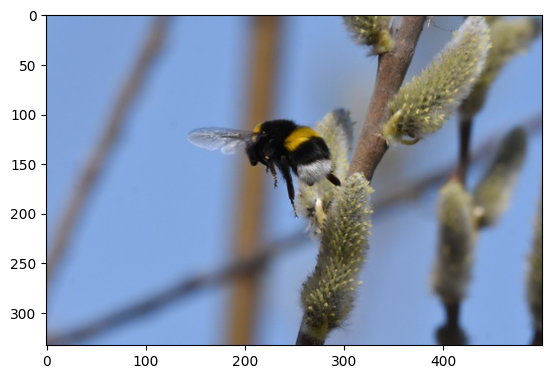

In [62]:
# load and normalize image
from myutils.loaders import get_img


input_image = get_img(2)
plt.imshow(input_image)
print(input_image.size)

# or load from URL...
# image_url = 'https://farm5.staticflickr.com/4141/4856248695_03475782dc_z.jpg'
# input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((352, 352)),
    ]
)
img = transform(input_image).unsqueeze(0)
print(img[0][0].shape)

TypeError: Invalid shape (3, 352, 352) for image data

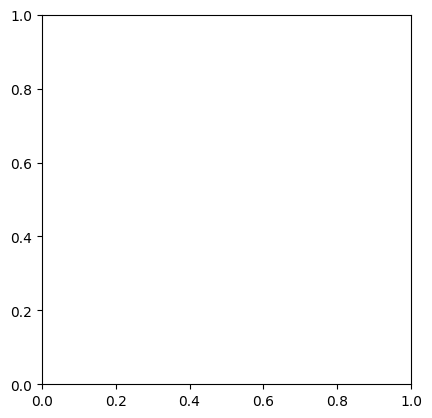

In [57]:
from myutils.loaders import get_img


# dss_pred = get_img(1, path="./dataset/preds/dss/0/", format="pt", _asTensor=True)
plt.imshow(img.squeeze(0))

In [53]:
inp = img.repeat(length, 1, 1, 1)
print(inp[0][0].shape)

torch.Size([352, 352])


In [31]:
isinstance(dss_pred, torch.Tensor)

True

In [47]:
a, b = input_image.size()

TypeError: 'tuple' object is not callable

In [39]:
input_image.size

TypeError: 'tuple' object is not callable

In [37]:
dss_pred.size()

torch.Size([1024, 1024])

In [32]:
isinstance(input_image, Image.Image)

True

In [11]:
dss_pred.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1024, 1024])

In [14]:
dss_inp = dss_pred.unsqueeze(0).expand(3, -1, -1).unsqueeze(0)

In [18]:
dss_pred.shape[0]

1024

[Text(0, -15, 'insect shaped')]

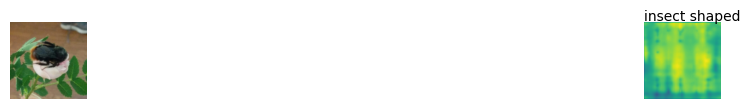

In [26]:
prompts = ["insect shaped"]
length = len(prompts)

with torch.no_grad():
    preds = model(dss_inp, prompts)[0]

preds: torch.Tensor = torch.nn.functional.interpolate(
    # eigenvector, size=(H_pad, W_pad), mode="bilinear"
    preds,
    size=(dss_pred.shape[1], dss_pred.shape[0]),
    mode="bicubic",
)

preds = preds.squeeze(0)

# visualize prediction
_, ax = plt.subplots(1, length + 1, figsize=(15, length))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(get_img(1))
[ax[i + 1].imshow(preds[i]) for i in range(length)]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(length)]

In [19]:
prompts = ["bee"]
length = len(prompts)

# predict
with torch.no_grad():
    preds = model(img.repeat(length, 1, 1, 1), prompts)[0]

preds: torch.Tensor = torch.nn.functional.interpolate(
    preds,
    size=(input_image.size[1], input_image.size[0]),
    mode="bicubic",
)
# preds = preds.squeeze(1)

# visualize prediction
_, ax = plt.subplots(1, length + 1, figsize=(15, length))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(length)]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(length)]

TypeError: upsample_bicubic2d() received an invalid combination of arguments - got (Tensor, tuple, bool, NoneType), but expected one of:
 * (Tensor input, tuple of ints output_size, bool align_corners, tuple of floats scale_factors)
      didn't match because some of the arguments have invalid types: (Tensor, !tuple of (Tensor, Tensor)!, bool, !NoneType!)
 * (Tensor input, tuple of ints output_size, bool align_corners, float scales_h, float scales_w, *, Tensor out)


[Text(0, -15, 'bee')]

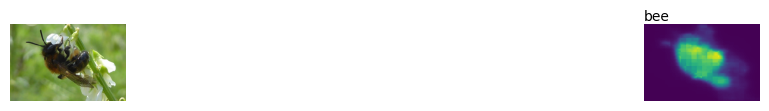

In [4]:
prompts = ["bee"]
length = len(prompts)

# predict
with torch.no_grad():
    preds = model(img.repeat(length, 1, 1, 1), prompts)[0]

preds: torch.Tensor = torch.nn.functional.interpolate(
    preds,
    size=(input_image.size[1], input_image.size[0]),
    mode="bicubic",
)
# preds = preds.squeeze(1)

# visualize prediction
_, ax = plt.subplots(1, length + 1, figsize=(15, length))
[a.axis("off") for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i + 1].imshow(torch.sigmoid(preds[i][0])) for i in range(length)]
[ax[i + 1].text(0, -15, prompts[i]) for i in range(length)]

[Text(0, -15, 'bees'), Text(0, -15, 'wing'), Text(0, -15, 'wings')]

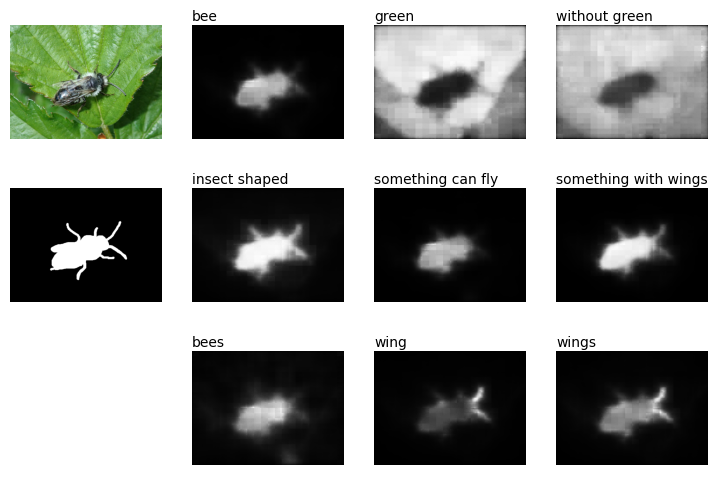

In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getIOU

prompts = ["bee", "green", "without green"]
prompts_2 = ["insect shaped", "something can fly", "something with wings"]
prompts_3 = ["bees", "wing", "wings"]
input_img = get_img(name="Andrena_cineraria_25107582_1")
preds = CLIPSeg.segment(input_img, prompts)
preds_2 = CLIPSeg.segment(input_img, prompts_2)
preds_3 = CLIPSeg.segment(input_img, prompts_3)
gt = torch.from_numpy(np.array(get_img(name="Andrena_cineraria_25107582_1", _gt=True).convert("1"))).long()

_, ax = plt.subplots(3, len(prompts) + 1, figsize=(len(prompts) * 3, len(prompts) * 2))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
ax[1][0].imshow(gt, cmap="gray")
[ax[0][i + 1].imshow(toGreyscale(preds[i], 2), cmap="gray") for i in range(len(prompts))]
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
[ax[1][i + 1].imshow(toGreyscale(preds_2[i], 2), cmap="gray") for i in range(len(prompts))]
[ax[1][i + 1].text(0, -15, prompts_2[i]) for i in range(len(prompts))]
[ax[2][i + 1].imshow(toGreyscale(preds_3[i], 2), cmap="gray") for i in range(len(prompts))]
[ax[2][i + 1].text(0, -15, prompts_3[i]) for i in range(len(prompts))]
# [ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), mode=2)[1]) for i in range(len(prompts))]
# [ax[2][i + 1].text(0, -15, getIOU(toBinary(toGreyscale(preds[i]), mode=2)[1], gt)) for i in range(len(prompts))]
# [ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), mode=2)[1]) for i in range(len(prompts))]
# [ax[3][i + 1].text(0, -15, getIOU(toBinary(toGreyscale(preds[i], 2), mode=2)[1], gt)) for i in range(len(prompts))]

[Text(0, -15, 'bee'),
 Text(0, -15, 'insect shaped'),
 Text(0, -15, 'something that has wings'),
 Text(0, -15, 'something that can fly'),
 Text(0, -15, 'a living creature'),
 Text(0, -15, 'a living creature that has wings')]

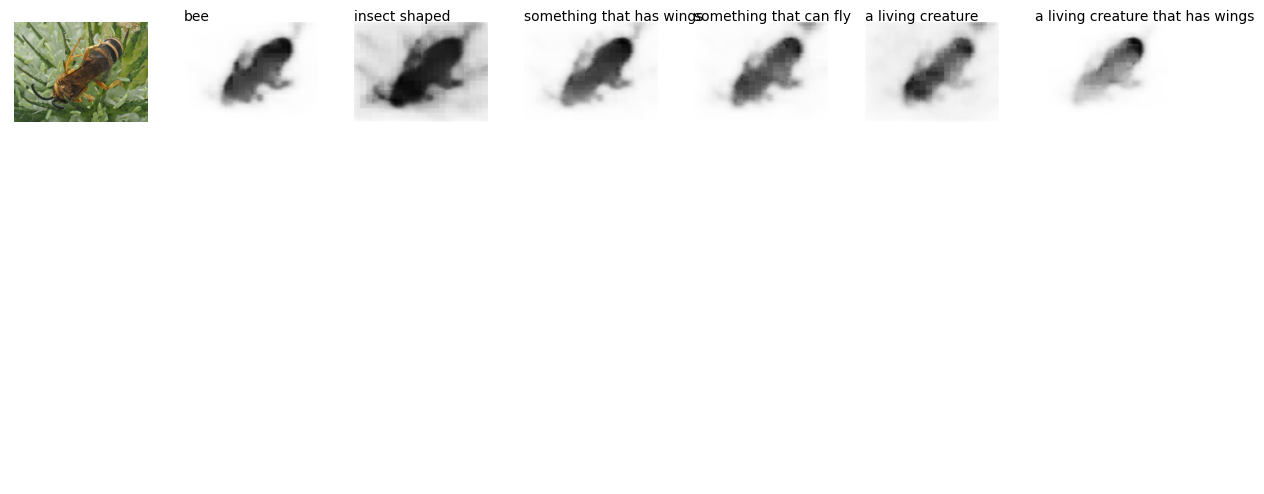

In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getIOU

prompts = [
    "bee",
    "insect shaped",
    "something that has wings",
    "something that can fly",
    "a living creature",
    "a living creature that has wings",
]
input_img = get_img(423)
preds = CLIPSeg.segment(input_img, prompts)
gt = torch.from_numpy(np.array(get_img(453, path="./dataset/masks/gt/").convert("1"))).long()

_, ax = plt.subplots(4, len(prompts) + 1, figsize=(15, len(prompts)))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
[ax[0][i + 1].imshow(toGreyscale(preds[i], 2), cmap="binary") for i in range(len(prompts))]
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
# [ax[1][i + 1].imshow(toGreyscale(preds[i], 2)) for i in range(len(prompts))]
# [ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), mode=2)[1]) for i in range(len(prompts))]
# [ax[2][i + 1].text(0, -15, getIOU(toBinary(toGreyscale(preds[i]), mode=2)[1], gt)) for i in range(len(prompts))]
# [ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), mode=2)[1]) for i in range(len(prompts))]
# [ax[3][i + 1].text(0, -15, getIOU(toBinary(toGreyscale(preds[i], 2), mode=2)[1], gt)) for i in range(len(prompts))]

c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Text(0, -15, '75.28 at t=0.4'),
 Text(0, -15, '78.65 at t=0.32'),
 Text(0, -15, '78.79 at t=0.28'),
 Text(0, -15, '16.08 at t=0.14'),
 Text(0, -15, '77.43 at t=0.16')]

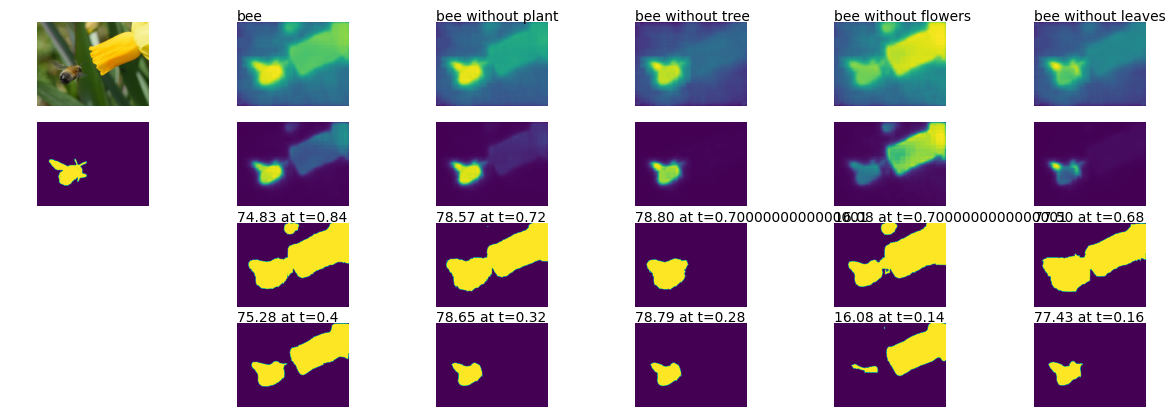

In [36]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getBestIOU, getIOU

prompts = ["bee", "bee without plant", "bee without tree", "bee without flowers", "bee without leaves"]
input_img = get_img(name="Anthophora_plumipes_5374660_1")
preds = CLIPSeg.segment(input_img, prompts)
gt = torch.from_numpy(
    np.array(get_img(name="Anthophora_plumipes_5374660_1", path="./dataset/masks/gt/").convert("1"))
).long()

_, ax = plt.subplots(4, len(prompts) + 1, figsize=(15, len(prompts)))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
ax[1][0].imshow(gt)
[ax[0][i + 1].imshow(toGreyscale(preds[i])) for i in range(len(prompts))]
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
[ax[1][i + 1].imshow(toGreyscale(preds[i], 2)) for i in range(len(prompts))]
[ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), mode=2)[1]) for i in range(len(prompts))]
[
    ax[2][i + 1].text(0, -15, f"{getBestIOU(preds[i], gt)[1]:.2f} at t={getBestIOU(preds[i], gt)[0]:.2f}")
    for i in range(len(prompts))
]
[ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), mode=2)[1]) for i in range(len(prompts))]
[
    ax[3][i + 1].text(
        0, -15, f"{getBestIOU(preds[i], gt, gs_mode=2)[1]:.2f} at t={getBestIOU(preds[i], gt, gs_mode=2)[0]:.2f}"
    )
    for i in range(len(prompts))
]

[Text(0, -15, '72.74 at t=0.32'),
 Text(0, -15, '76.20 at t=0.50'),
 Text(0, -15, '79.91 at t=0.24'),
 Text(0, -15, '21.57 at t=0.22'),
 Text(0, -15, '63.11 at t=0.18')]

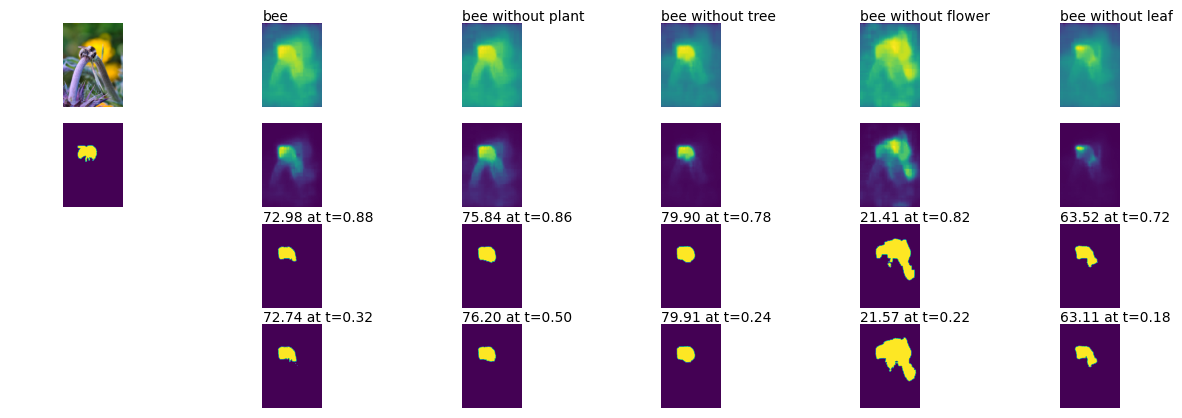

In [48]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getBestIOU, getIOU

prompts = ["bee", "bee without plant", "bee without tree", "bee without flower", "bee without leaf"]
input_img = get_img(name="Bombus_sylvarum_79524991_1")
preds = CLIPSeg.segment(input_img, prompts)
gt = torch.from_numpy(
    np.array(get_img(name="Bombus_sylvarum_79524991_1", path="./dataset/masks/gt/").convert("1"))
).long()

_, ax = plt.subplots(4, len(prompts) + 1, figsize=(15, len(prompts)))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
ax[1][0].imshow(gt)
[ax[0][i + 1].imshow(toGreyscale(preds[i])) for i in range(len(prompts))]  # Min-Max
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
[ax[1][i + 1].imshow(toGreyscale(preds[i], 2)) for i in range(len(prompts))]  # Sigmoid
best_ious_mm = [getBestIOU(preds[i], gt) for i in range(len(prompts))]
best_ious_s = [getBestIOU(preds[i], gt, 2) for i in range(len(prompts))]
[ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), best_ious_mm[i][0])) for i in range(len(prompts))]
[ax[2][i + 1].text(0, -15, f"{best_ious_mm[i][1]:.2f} at t={best_ious_mm[i][0]:.2f}") for i in range(len(prompts))]
[ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), best_ious_s[i][0])) for i in range(len(prompts))]
[ax[3][i + 1].text(0, -15, f"{best_ious_s[i][1]:.2f} at t={best_ious_s[i][0]:.2f}") for i in range(len(prompts))]

[Text(0, -15, '72.74 at t=0.32'),
 Text(0, -15, '63.68 at t=0.40'),
 Text(0, -15, '76.50 at t=0.10'),
 Text(0, -15, '19.95 at t=0.18'),
 Text(0, -15, '68.26 at t=0.18')]

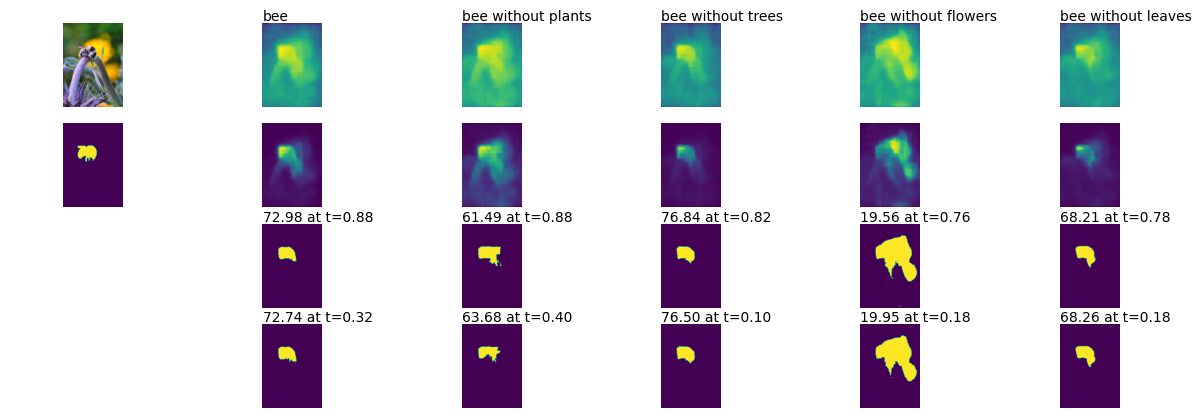

In [46]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getBestIOU, getIOU

prompts = ["bee", "bee without plants", "bee without trees", "bee without flowers", "bee without leaves"]
input_img = get_img(name="Bombus_sylvarum_79524991_1")
preds = CLIPSeg.segment(input_img, prompts)
gt = torch.from_numpy(
    np.array(get_img(name="Bombus_sylvarum_79524991_1", path="./dataset/masks/gt/").convert("1"))
).long()

_, ax = plt.subplots(4, len(prompts) + 1, figsize=(15, len(prompts)))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
ax[1][0].imshow(gt)
[ax[0][i + 1].imshow(toGreyscale(preds[i])) for i in range(len(prompts))]  # Min-Max
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
[ax[1][i + 1].imshow(toGreyscale(preds[i], 2)) for i in range(len(prompts))]  # Sigmoid
best_ious_mm = [getBestIOU(preds[i], gt) for i in range(len(prompts))]
best_ious_s = [getBestIOU(preds[i], gt, 2) for i in range(len(prompts))]
[ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), best_ious_mm[i][0])) for i in range(len(prompts))]
[ax[2][i + 1].text(0, -15, f"{best_ious_mm[i][1]:.2f} at t={best_ious_mm[i][0]:.2f}") for i in range(len(prompts))]
[ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), best_ious_s[i][0])) for i in range(len(prompts))]
[ax[3][i + 1].text(0, -15, f"{best_ious_s[i][1]:.2f} at t={best_ious_s[i][0]:.2f}") for i in range(len(prompts))]

c:\Users\yitao\.conda\envs\test\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Text(0, -15, '72.74 at t=0.32'),
 Text(0, -15, '79.91 at t=0.24'),
 Text(0, -15, '79.35 at t=0.12'),
 Text(0, -15, '80.34 at t=0.26'),
 Text(0, -15, '79.92 at t=0.12'),
 Text(0, -15, '80.94 at t=0.20')]

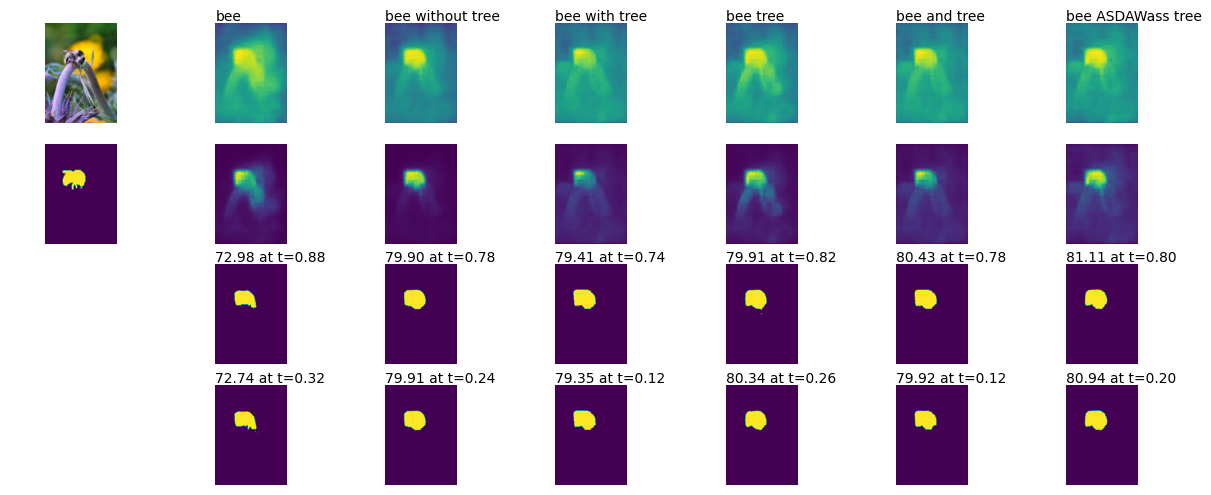

In [49]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from myutils import CLIPSeg
from myutils.loaders import get_img
from myutils.processors import toBinary, toGreyscale
from myutils.score import getBestIOU, getIOU

prompts = ["bee", "bee without tree", "bee with tree", "bee tree", "bee and tree", "bee ASDAWass tree"]
input_img = get_img(name="Bombus_sylvarum_79524991_1")
preds = CLIPSeg.segment(input_img, prompts)
gt = torch.from_numpy(
    np.array(get_img(name="Bombus_sylvarum_79524991_1", path="./dataset/masks/gt/").convert("1"))
).long()

_, ax = plt.subplots(4, len(prompts) + 1, figsize=(15, len(prompts)))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_img)
ax[1][0].imshow(gt)
[ax[0][i + 1].imshow(toGreyscale(preds[i])) for i in range(len(prompts))]  # Min-Max
[ax[0][i + 1].text(0, -15, prompts[i]) for i in range(len(prompts))]
[ax[1][i + 1].imshow(toGreyscale(preds[i], 2)) for i in range(len(prompts))]  # Sigmoid
best_ious_mm = [getBestIOU(preds[i], gt) for i in range(len(prompts))]
best_ious_s = [getBestIOU(preds[i], gt, 2) for i in range(len(prompts))]
[ax[2][i + 1].imshow(toBinary(toGreyscale(preds[i]), best_ious_mm[i][0])) for i in range(len(prompts))]
[ax[2][i + 1].text(0, -15, f"{best_ious_mm[i][1]:.2f} at t={best_ious_mm[i][0]:.2f}") for i in range(len(prompts))]
[ax[3][i + 1].imshow(toBinary(toGreyscale(preds[i], 2), best_ious_s[i][0])) for i in range(len(prompts))]
[ax[3][i + 1].text(0, -15, f"{best_ious_s[i][1]:.2f} at t={best_ious_s[i][0]:.2f}") for i in range(len(prompts))]